# Groundtruth file

Notebook used to generate the ground truth according to the position of prisms in post-process.

In [2]:
import sys
sys.path.append("../")
import numpy as np
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_utils as theodo_u
import warnings
warnings.filterwarnings('ignore')

In [10]:
theodo_u = importlib.reload(theodo_u)
path = "../data/20220525-2/"
prefix = "filtered_prediction/f-2-1-1-3-2-0-L"
linear_interpolation = True
if(linear_interpolation==True):
    P1 = theodo_u.read_prediction_data_Linear_csv_file(path+prefix +"_1.csv")
    P2 = theodo_u.read_prediction_data_Linear_csv_file(path+prefix +"_2.csv")
    P3 = theodo_u.read_prediction_data_Linear_csv_file(path+prefix +"_3.csv")
else:
    P1 = theodo_u.read_prediction_data_GP_csv_file(path+prefix +"_1.csv")
    P2 = theodo_u.read_prediction_data_GP_csv_file(path+prefix +"_2.csv")
    P3 = theodo_u.read_prediction_data_GP_csv_file(path+prefix +"_3.csv")

In [11]:
P1_arr = np.array(P1)
P2_arr = np.array(P2)
P3_arr = np.array(P3)

path_file_GCP = "total_stations/GCP.txt"
file_name = path+path_file_GCP
trimble_1_gcp, trimble_2_gcp, trimble_3_gcp, T_1_grand, T_2_grand, T_3_grand = theodo_u.read_marker_file(file_name, 1, 1)

P1_corrected = []
P2_corrected = []
P3_corrected = []
for i, j, k in zip(P1_arr, P2_arr, P3_arr):
    P1_arr = T_1_grand@i[1:5].T
    P1_corrected.append([i[0], P1_arr[0], P1_arr[1], P1_arr[2], 1])
    P2_arr = T_2_grand@j[1:5].T
    P2_corrected.append([j[0], P2_arr[0], P2_arr[1], P2_arr[2], 1])
    P3_arr = T_3_grand@k[1:5].T
    P3_corrected.append([k[0], P3_arr[0], P3_arr[1], P3_arr[2], 1])

P1_corrected = np.array(P1_corrected)
P2_corrected = np.array(P2_corrected)
P3_corrected = np.array(P3_corrected)


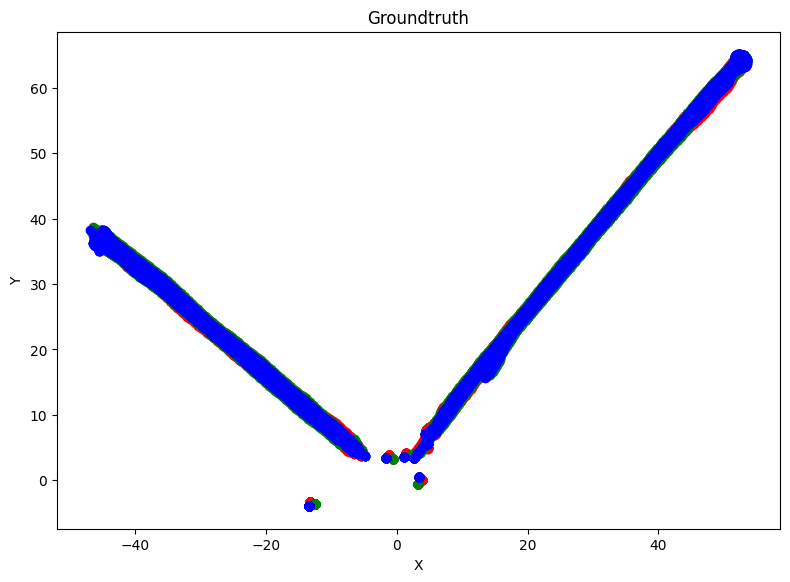

In [12]:
fig = plt.figure(figsize = (8, 6))
ax = plt.axes()
begin = 0
end = -1
ax.scatter(P1_corrected[begin:end,1],P1_corrected[begin:end,2], color='red')
ax.scatter(P2_corrected[begin:end,1],P2_corrected[begin:end,2], color='green')
ax.scatter(P3_corrected[begin:end,1],P3_corrected[begin:end,2], color='blue')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Groundtruth")
ax.set_aspect('equal')
fig.tight_layout() 

In [13]:
# Load sensor positions
from scripts.theodolite_utils import read_file
sensor = read_file(path + "sensors_extrinsic_calibration/sensor_position_lidar_frame.csv")
P1_lidar, P2_lidar, P3_lidar = sensor[0:3]
P = np.array([P1_lidar, P2_lidar, P3_lidar]).T

In [14]:
# Doing a minimization between these not moving points, and the 3D prism coordinates
# Pose_lidar is a list of each rigid transform founded
list_lidar_time = []
Pose_lidar = []
Prism_corrected = []
number = len(P1)
for i in range(0,number):
    Q = np.array([P1_corrected[i,1:4], P2_corrected[i,1:4], P3_corrected[i,1:4]]).T
    Q =np.concatenate((Q, np.array([[1,1,1]])), axis=0)
    T = theodo_u.point_to_point_minimization(P, Q)
    Pose_lidar.append(T)
    prism_correct = T@P
    Prism_corrected.append(prism_correct)
    list_lidar_time.append(P1_corrected[i,0])
Pose_lidar_arr = np.array(Pose_lidar)
Prism_corrected_arr = np.array(Prism_corrected)

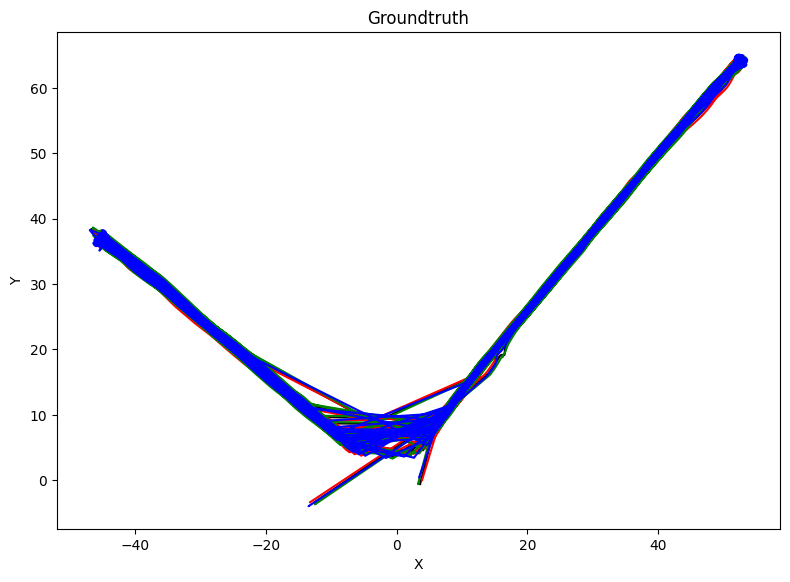

In [15]:
%matplotlib inline
fig = plt.figure(figsize = (8, 6))
ax = plt.axes()
begin = 0
end = -1
ax.plot(Pose_lidar_arr[begin:end,0,3],Pose_lidar_arr[begin:end,1,3], color='black')
ax.plot(Prism_corrected_arr[begin:end,0,0],Prism_corrected_arr[begin:end,1,0], color='red')
ax.plot(Prism_corrected_arr[begin:end,0,1],Prism_corrected_arr[begin:end,1,1], color='green')
ax.plot(Prism_corrected_arr[begin:end,0,2],Prism_corrected_arr[begin:end,1,2], color='blue')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Groundtruth")
ax.set_aspect('equal')
fig.tight_layout() 

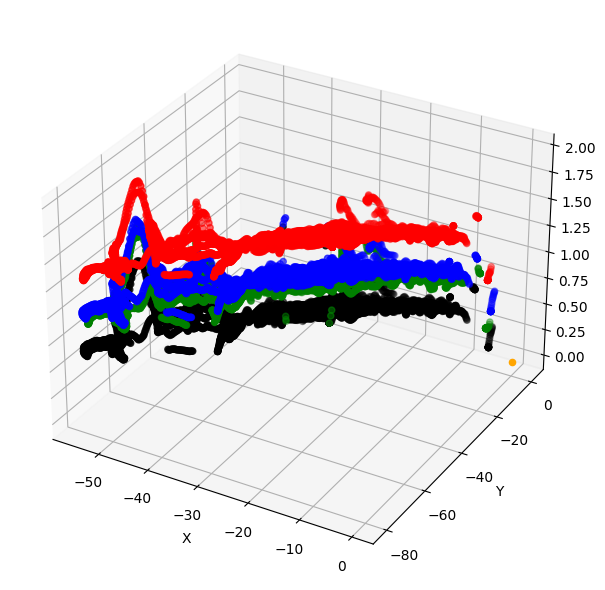

In [30]:
%matplotlib inline
fig = plt.figure(figsize = (8, 6))
ax = plt.axes(projection ="3d")
ax.scatter3D(Pose_lidar_arr[begin:end,0,3],Pose_lidar_arr[begin:end,1,3],Pose_lidar_arr[begin:end,2,3], color='black')
ax.scatter3D(Prism_corrected_arr[begin:end,0,0],Prism_corrected_arr[begin:end,1,0],Prism_corrected_arr[begin:end,2,0], color='red')
ax.scatter3D(Prism_corrected_arr[begin:end,0,1],Prism_corrected_arr[begin:end,1,1],Prism_corrected_arr[begin:end,2,1], color='green')
ax.scatter3D(Prism_corrected_arr[begin:end,0,2],Prism_corrected_arr[begin:end,1,2],Prism_corrected_arr[begin:end,2,2], color='blue')
ax.scatter3D(0,0,0, color='orange')
ax.set_xlabel("X")
ax.set_ylabel("Y")
fig.tight_layout()

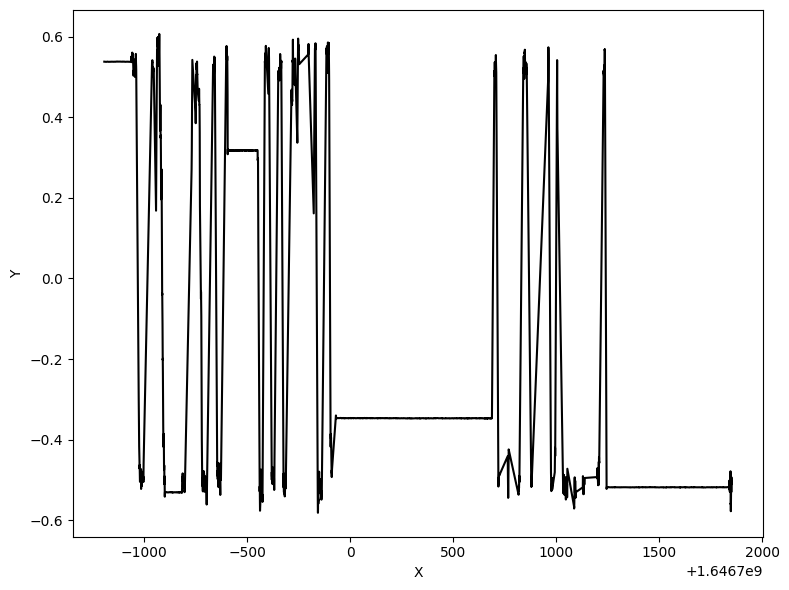

In [21]:
%matplotlib inline
fig = plt.figure(figsize = (8, 6))
ax = plt.axes()
ax.plot(list_lidar_time,Pose_lidar_arr[:,0,2], color='black')
ax.set_xlabel("X")
ax.set_ylabel("Y")
fig.tight_layout()

In [16]:
theodo_u = importlib.reload(theodo_u)
theodo_u.grountruth_GP_convert_for_eval(list_lidar_time, Pose_lidar, path+"ground_truth/groundtruth_rts_lidar.csv")

Conversion done !
